# Dataset Creation & Processing

## 0 Imports

In [1]:
%cd ..

/home/ahs/AHS-uni/Projects/docrag


In [2]:
from pprint import pprint
from docrag.datasets import (
    load_corpus_dataset,
    load_qa_dataset,
    CorpusIndex,
    project_fields,
    filter_dataset,
    add_images,
    push_dataset_to_hub,
)

### Utilities

In [3]:
from PIL import Image

def show_thumbnail(img: Image.Image, max_width: int = 1024):
    aspect = img.height / img.width
    resized = img.resize((max_width, int(max_width * aspect)))
    display(resized)

## 1 Loading Datasets

We ship two loaders in `datasets`:

- **`load_corpus_dataset(root, ...)`** – page-level manifest (`corpus.jsonl`) → `Dataset`
- **`load_qa_dataset(root, ...)`**     – train/val/test QA splits → `DatasetDict`

In [4]:
dataset_root = "data/mpdocvqa-sample"

corpus_ds = load_corpus_dataset(dataset_root)
qa_ds = load_qa_dataset(dataset_root) 

*If you do not have the dataset files available locally, you can also download them from Hugging Face*

In [5]:
# # Loading from Hugging Face
# from datasets import load_dataset

# corpus_ds = load_dataset("AHS-uni/mpdocvqa-sample-corpus") # DatasetDict
# qa_ds = load_qa_dataset("AHS-uni/mpdocvqa-sample-qa") # DatasetDict

In [6]:
# QA dataset splits
qa_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'document', 'evidence', 'answer', 'tags'],
        num_rows: 50
    })
    val: Dataset({
        features: ['id', 'question', 'document', 'evidence', 'answer', 'tags'],
        num_rows: 1
    })
    test: Dataset({
        features: ['id', 'question', 'document', 'evidence', 'answer', 'tags'],
        num_rows: 11
    })
})

In [7]:
# QA dataset schema
qa_ds["train"].features

{'id': Value(dtype='string', id=None),
 'question': {'id': Value(dtype='string', id=None),
  'text': Value(dtype='string', id=None),
  'type': ClassLabel(names=['extractive', 'verification', 'counting', 'arithmetic', 'abstractive', 'procedural', 'reasoning', 'other'], id=None),
  'tags': [{'name': ClassLabel(names=['missing', 'low_quality', 'inferred', 'predicted'], id=None),
    'target': Value(dtype='string', id=None),
    'comment': Value(dtype='string', id=None)}]},
 'document': {'id': Value(dtype='string', id=None),
  'type': ClassLabel(names=['legal', 'financial', 'scientific', 'technical', 'policy', 'correspondence', 'marketing', 'personal_record', 'news', 'other'], id=None),
  'num_pages': Value(dtype='int32', id=None),
  'tags': [{'name': ClassLabel(names=['missing', 'low_quality', 'inferred', 'predicted'], id=None),
    'target': Value(dtype='string', id=None),
    'comment': Value(dtype='string', id=None)}]},
 'evidence': {'pages': Sequence(feature=Value(dtype='int32', id=No

In [8]:
# Corpus dataset features
corpus_ds.features

{'doc_id': Value(dtype='string', id=None),
 'page_number': Value(dtype='int32', id=None),
 'image': Image(mode=None, decode=True, id=None)}

---

## 2 Fast Page Lookup with `CorpusIndex`

`CorpusIndex` builds two dicts:

- `(doc_id, page_num)` → absolute row index  
- `doc_id`             → list_of_row_indices

That makes random access and batched fetches trivial.

`CorpusIndex` also provides a number of methods for fetching size:

- `get_page`: Fetch a given page from a document.
- `get_pages`: Fetch a set of pages from a document.
- `get_document_pages`: Fetch all pages from a document.
- `get_batch_document_pages`: Fetch all pages from a batch of documents.

In [9]:
corpus_index = CorpusIndex(corpus_ds)

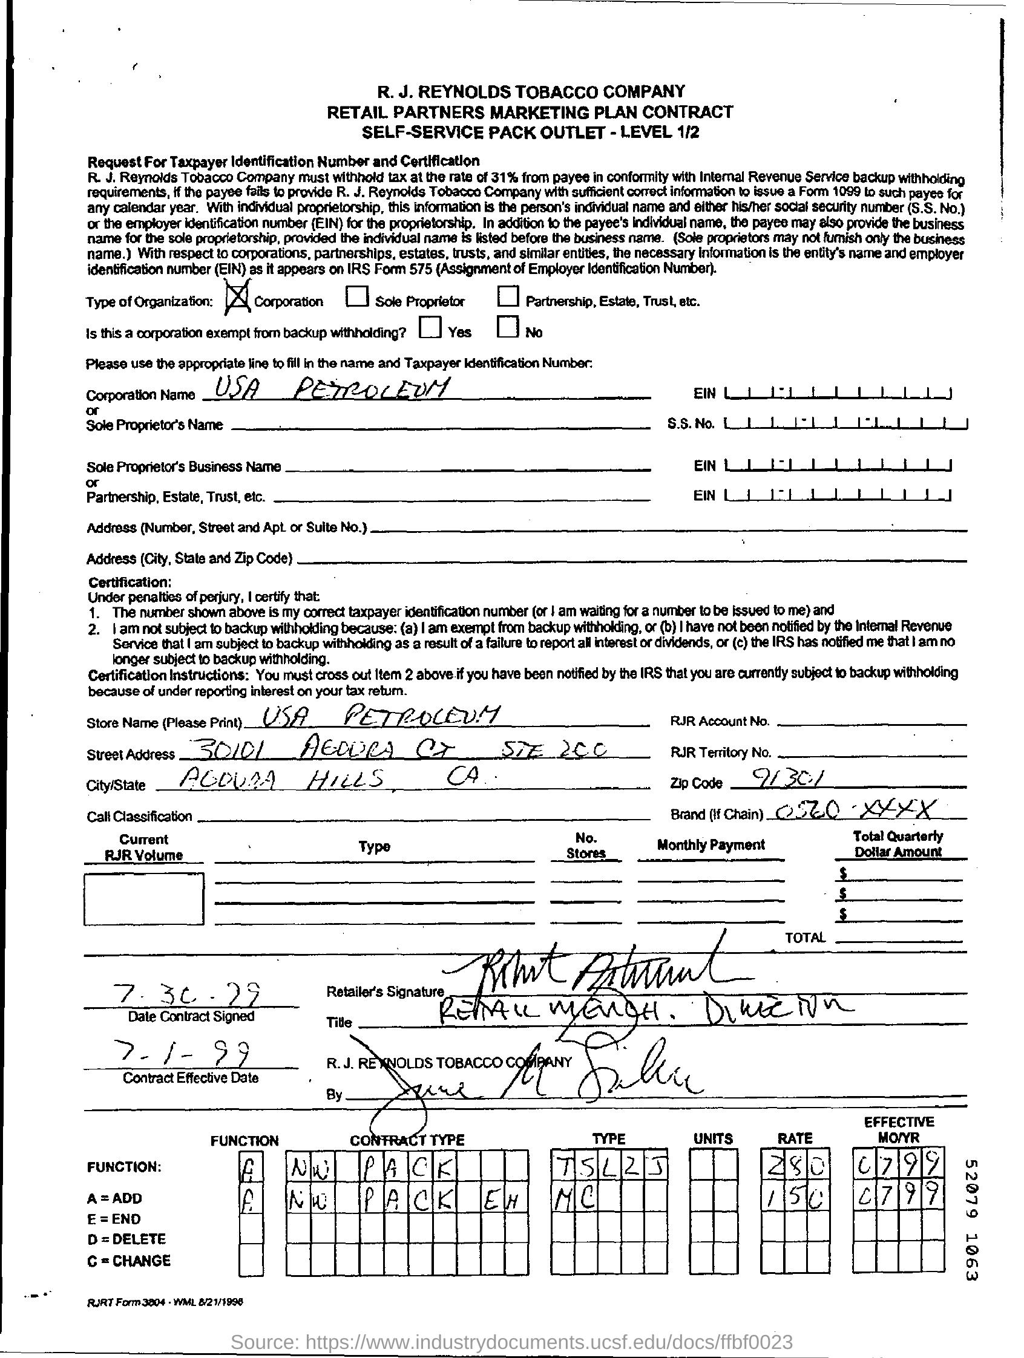

In [10]:
# Fetch a single page image (as PIL.Image)
img = corpus_index.get_page("ffbf0023", 3)
show_thumbnail(img)

## 3 Task Specific Views and Adding Image Columns

### Creating a Task Specific View

Most downstream tasks don’t need the *entire* unified schema.  
With **`project_fields`** you create a slim Dataset containing exactly
the columns you care about, while *preserving* their feature types
(`ClassLabel`, nested `Sequence`, …).

#### Example: VQA Dataset 


We can either define the selected fields as a list of *dotted-string* paths and `project_fields` will infer new column names for us.

In [11]:
vqa_fields = [
    "id",
    "document.id",
    "question.text",
    "answer.variants",    
    "evidence.pages",
]

Or we can define them as a `dict` containing the new column names we want for each field.

In [12]:
vqa_fields = {
    "id": "id",
    "document_name": "document.id",
    "answers": "answer.variants",
    "evidence_pages": "evidence.pages"
}

In [13]:
vqa_ds = project_fields(
    qa_ds["train"],
    select_fields=vqa_fields,
    # batched=True,         # batched processing for large datasets
    # batch_size=2048,
)

In [14]:
# VQA dataset features
vqa_ds.features

{'id': Value(dtype='string', id=None),
 'document_name': Value(dtype='string', id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'evidence_pages': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)}

In [15]:
# Exmaple row
vqa_ds[3]

{'id': 'ffcn0226-1480',
 'document_name': 'ffcn0226',
 'answers': ['The Fertilizer Institute'],
 'evidence_pages': [13]}

#### Example: Retrieval Dataset

If we wanted to create a retrieval dataset, where the goal is to find the evidence pages in a document given a question as query, we'd just  have to call `project_fields` with a different set of fields.

In [16]:
retrieval_fields = {
    "id": "id",
    "query": "question.text",
    "document_name": "document.id",
    "evidence_pages": "evidence.pages",
}

retrieval_ds = project_fields(
    qa_ds["train"],
    select_fields=retrieval_fields,
)

In [20]:
# Dataset features
retrieval_ds.features

{'id': Value(dtype='string', id=None),
 'query': Value(dtype='string', id=None),
 'document_name': Value(dtype='string', id=None),
 'evidence_pages': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)}

In [21]:
# Example row
retrieval_ds[5]

{'id': 'ffcn0226-1483',
 'query': 'What is the full form CSA?',
 'document_name': 'ffcn0226',
 'evidence_pages': [13]}

## Adding an `images` Column

Some some downstream tasks may require more than just the QA data, and may also need some image data from the corpus.  
With **`add_images`** you can add image columns to the dataset to produce a complete multimodal dataset.

#### Example: VQA Dataset

Continuing the VQA dataset example, we can now add the edivence page images to the dataset.  
For this we will use the `add_images` function.

We just have to specify the mode: "evidence_pages", and tell it where to look for the pages to add.

In [17]:
vqa_ds = add_images(
    vqa_ds,
    corpus_index,
    mode="evidence_pages",
    document_id_path="document_name",
    evidence_pages_path="evidence_pages",
    # batched=True,         # batched processing for large datasets
    # batch_size=2048,
)

In [18]:
# Dataset features
vqa_ds.features

{'id': Value(dtype='string', id=None),
 'document_name': Value(dtype='string', id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'evidence_pages': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'images': [Image(mode=None, decode=True, id=None)]}

In [19]:
# Example row
vqa_ds[5]

{'id': 'ffcn0226-1483',
 'document_name': 'ffcn0226',
 'answers': ['Contract Services Association'],
 'evidence_pages': [13],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1700x2235>]}

## 3 Filtering Datasets

## 4 Creating New Datasets

We dont necessarilly need to use the `datasets` utilities for dataset manipulation, we can also use them for dataset creeation.

#### Example: Document Classification Dataset 

For this example, we'll load a different dataset.

This dataset only has one split so we have specify that when we go to load it.  
> *this wouldn't be a concern if we were loading from Hugging Face*

In [24]:
dataset_root = "data/mmlongbenchdoc-sample"

splits = {
    "test": "unified_qas/mmlongbenchdoc.jsonl",
}

corpus_ds = load_corpus_dataset(dataset_root)
qa_ds = load_qa_dataset(dataset_root, splits=splits) 

Generating test split: 0 examples [00:00, ? examples/s]

We'll start by making an index for the corpus

In [25]:
corpus_index = CorpusIndex(corpus_ds)

To make the classification dataset, we'll need all the documents in this dataset.  
Every document ID that appears in the indexed dataset is already stored as a key in `CorpusIndex.document_to_indices`, so we can just use that.

In [ ]:
all_document_ids = list(corpus_index.documents_to_indicies.keys())